# Overview

- Setup
- Read image
- 4 properties of a `sitk.Image`
- Display the middle z slice
- SITK and numpy indexing reversed
- Try displaying middle x and y slices
- Misoriented...
- Which properties did `DICOMOrientImageFilter` change
- Orient for sagittal and coronal views
- 2D rotation
- Interactive 2D rotation
- 3D rotation
- Interactive 3D rotation
- Rotations for all views

# Setup

In [1]:
# Image processing
import SimpleITK as sitk
import numpy as np

# Image rendering
import matplotlib.pyplot as plt

%matplotlib inline
from ipywidgets import interact, fixed

# Miscellaneous
from pathlib import Path
from pprint import pprint
from rotations_helpers import degrees_to_radians, disp_slice, resample_2d_rotation, resample_3d_rotation, View

# Set up directories
# When running the Jupyter notebook, cwd() is TechTalk/src/
HOME_DIR = Path.cwd().parents[0]
EXAMPLE_DATA_DIR = HOME_DIR / "ExampleData"

# The extensions we support in our project. Not a complete list.
# See https://simpleitk.readthedocs.io/en/master/IO.html for everything that sitk supports.
SUPPORTED_EXTENSIONS: tuple = ("*.nii.gz", "*.nii", "*.nrrd")

EXAMPLE_DATA_PATHS: list[Path] = list()
for extension in SUPPORTED_EXTENSIONS:
    for path in EXAMPLE_DATA_DIR.glob(extension):
        EXAMPLE_DATA_PATHS.append(path)

# Read image

Create a `sitk.ImageFileReader` to read files, then store the images in variables.

[List of extensions supported](https://simpleitk.readthedocs.io/en/master/IO.html)

In [2]:
READER: sitk.ImageFileReader = sitk.ImageFileReader()

nifti_path: Path = EXAMPLE_DATA_PATHS[0]
READER.SetFileName(str(nifti_path))
nifti_3d: sitk.Image = READER.Execute()

nrrd_path: Path = EXAMPLE_DATA_PATHS[-1]
# We need only give ImageFileReader a file path.
# It will automatically detect the file type.
READER.SetFileName(str(nrrd_path))
nrrd_3d: sitk.Image = READER.Execute()

# 4 properties of a `sitk.Image`

* Origin
* Size
* Spacing
* Direction matrix

In [3]:
properties: dict = {
    "origin": nifti_3d.GetOrigin(),
    "size": nifti_3d.GetSize(),
    "spacing": nifti_3d.GetSpacing(),
    "direction": nifti_3d.GetDirection(),
}
ORIGIN = properties["origin"]
SIZE = properties["size"]
SPACING = properties["spacing"]
DIRECTION = properties["direction"]

properties

{'origin': (96.10041046142578, 134.1010284423828, -72.0984878540039),
 'size': (244, 292, 198),
 'spacing': (0.7991799712181091, 0.7979450225830078, 0.8030300140380859),
 'direction': (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)}

# Display the middle z slice

Here, we have to convert the `sitk.Image` to a `numpy` array to render it in this notebook.

In our project, we also have to convert to `numpy` array to render in the GUI.

Essentially, numpy is a secondary image processing/rendering library.

		Axial


(-0.5, 243.5, 291.5, -0.5)

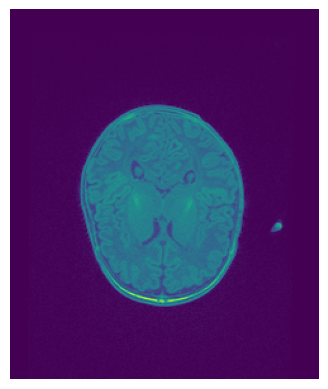

In [4]:
z_center: int = (SIZE[2] - 1) // 2
slice_middle_z: sitk.Image = nifti_3d[:, :, z_center]

print("\t\tAxial")
# Convert sitk.Image to numpy array
# NOTE: This returns the transpose of the sitk representation
slice_np: np.ndarray = sitk.GetArrayFromImage(slice_middle_z)
plt.imshow(slice_np)
plt.axis("off")

# From now on, will use disp_slice(img_2d: sitk.Image)
# It does the same thing as above

# However, SimpleITK and numpy indexing are in [opposite order](https://simpleitk.org/SPIE2019_COURSE/02_images_and_resampling.html#SimpleITK2Numpy-and-Numpy2SimpleITK)!

SimpleITK: `[x, y, z]`

numpy: `[z, y, x]`

In [5]:
print(f"sitk.Image dimensions: {SIZE}")
nifti_3d_np: np.ndarray = sitk.GetArrayFromImage(nifti_3d)
print(f"ndarray dimensions: {nifti_3d_np.shape}")

# Looping over all values would take too long
for x in range(0, SIZE[0], 25):
    for y in range(0, SIZE[1], 25):
        for z in range(0, SIZE[2], 25):
            assert nifti_3d.GetPixel(x, y, z) == nifti_3d_np[z][y][x]

sitk.Image dimensions: (244, 292, 198)
ndarray dimensions: (198, 292, 244)


# Try displaying middle x and y slices

				Sagittal


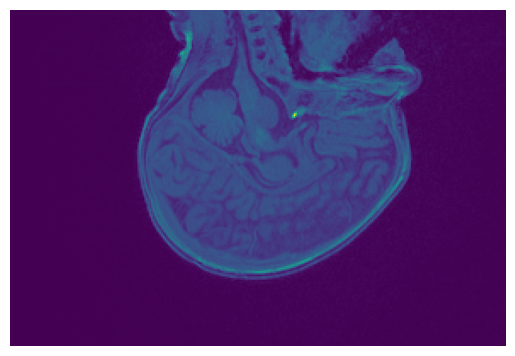

				Coronal


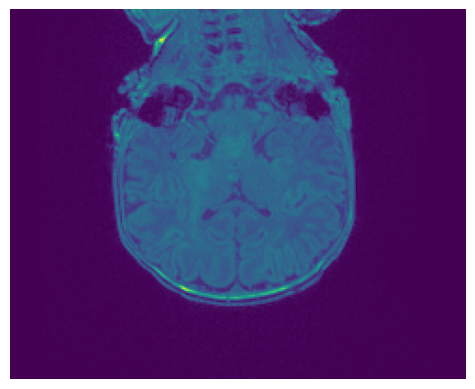

In [6]:
x_center: int = (SIZE[0] - 1) // 2
y_center: int = (SIZE[1] - 1) // 2

print("\t\t\t\tSagittal")
disp_slice(nifti_3d[x_center, :, :])
print("\t\t\t\tCoronal")
disp_slice(nifti_3d[:, y_center, :])

# Misoriented... orient the image to follow ITK-SNAP radiological conventions

[ITK-SNAP](http://www.itksnap.org) is an official medical image viewer. Let's orient this image for the **axial view** using the [`DICOMOrientImageFilter`](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DICOMOrientImageFilter.html#details).

Btw, `DICOMOrientImageFilter` will orient any image, even a very misaligned one such as `ExampleData/IBIS_Dataset_NotAligned_6month_T1w.nrrd` in the same way (i.e., will be aligned the same as the below screenshot for all 3 views).

![NIfTI image in ITK-SNAP](../img/NIfTI_ITKSNAP_annotated.png)

		Axial


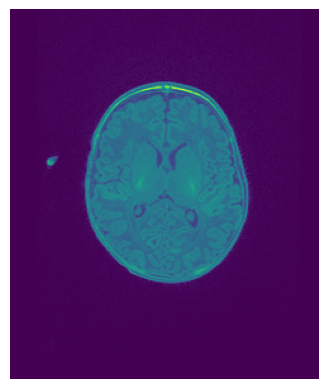

In [7]:
AXIAL_ORIENTATION_STR = "LPS"
ORIENT_FILTER: sitk.DICOMOrientImageFilter = sitk.DICOMOrientImageFilter()
ORIENT_FILTER.SetDesiredCoordinateOrientation(AXIAL_ORIENTATION_STR)

nifti_3d_axial: sitk.Image = ORIENT_FILTER.Execute(nifti_3d)
slice_axial: sitk.Image = nifti_3d_axial[:, :, z_center]

print("\t\tAxial")
disp_slice(slice_axial)

# Which of the four properties did `DICOMOrientImageFilter` change?

In [8]:
properties_axial: dict = {
    "origin": nifti_3d_axial.GetOrigin(),
    "size": nifti_3d_axial.GetSize(),
    "spacing": nifti_3d_axial.GetSpacing(),
    "direction": nifti_3d_axial.GetDirection(),
}
ORIGIN_AXIAL = properties_axial["origin"]
SIZE_AXIAL = properties_axial["size"]
SPACING_AXIAL = properties_axial["spacing"]
DIRECTION_AXIAL = properties_axial["direction"]

print("nifti_3d")
pprint(properties)
print()
print("nifti_3d_axial")
pprint(properties_axial)

nifti_3d
{'direction': (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0),
 'origin': (96.10041046142578, 134.1010284423828, -72.0984878540039),
 'size': (244, 292, 198),
 'spacing': (0.7991799712181091, 0.7979450225830078, 0.8030300140380859)}

nifti_3d_axial
{'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 'origin': (-98.10032254457474, -98.10097312927246, -72.0984878540039),
 'size': (244, 292, 198),
 'spacing': (0.7991799712181091, 0.7979450225830078, 0.8030300140380859)}


# Orient for sagittal and coronal views

				Sagittal


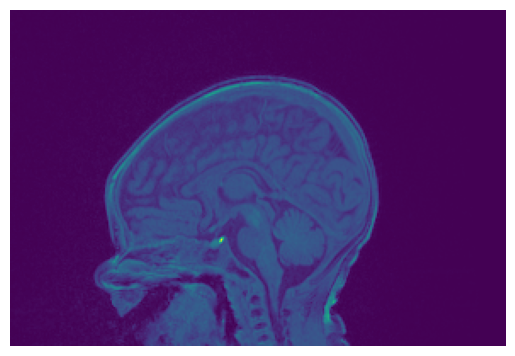

				Coronal


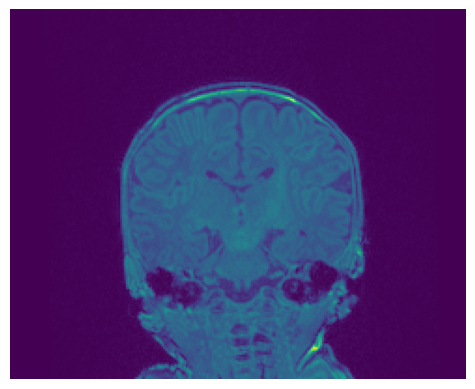

In [9]:
SAGITTAL_ORIENTATION_STR: str = "RPI"
CORONAL_ORIENTATION_STR: str = "LPI"

ORIENT_FILTER.SetDesiredCoordinateOrientation(SAGITTAL_ORIENTATION_STR)
nifti_3d_sagittal: sitk.Image = ORIENT_FILTER.Execute(nifti_3d)

ORIENT_FILTER.SetDesiredCoordinateOrientation(CORONAL_ORIENTATION_STR)
nifti_3d_coronal: sitk.Image = ORIENT_FILTER.Execute(nifti_3d)

print("\t\t\t\tSagittal")
disp_slice(nifti_3d_sagittal[x_center, :, :])
print("\t\t\t\tCoronal")
disp_slice(nifti_3d_coronal[:, y_center, :])

# 2D rotation using `Euler2DTransform`

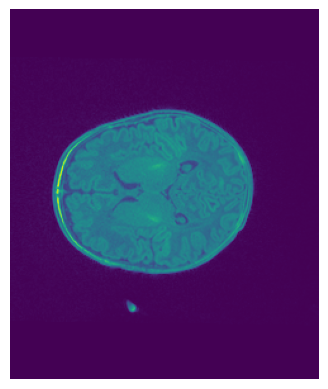

In [10]:
euler_2d_transform: sitk.Euler2DTransform = sitk.Euler2DTransform()
euler_2d_transform.SetCenter(
    slice_axial.TransformContinuousIndexToPhysicalPoint(
        [(dimension - 1) / 2.0 for dimension in slice_axial.GetSize()]
    )
)

euler_2d_transform.SetAngle(degrees_to_radians(90))

rotated_slice: sitk.Image = sitk.Resample(slice_axial, euler_2d_transform)
disp_slice(rotated_slice)


# Interactive 2D rotation

In [11]:
interact(
    resample_2d_rotation,
    img_2d=fixed(slice_axial),
    euler_2d_transform = fixed(euler_2d_transform),
    theta=(0, 360)
)

interactive(children=(IntSlider(value=180, description='theta', max=360), Output()), _dom_classes=('widget-int…

<function rotations_helpers.resample_2d_rotation(img_2d: SimpleITK.SimpleITK.Image, euler_2d_transform: SimpleITK.SimpleITK.Euler2DTransform, theta: int) -> None>

# 3D rotation using `Euler3DTransform`

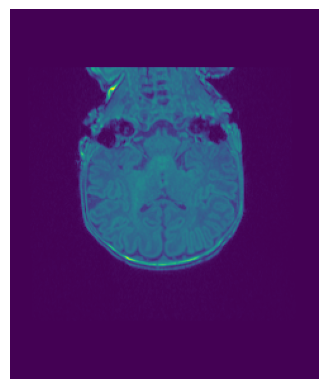

In [12]:
euler_3d_transform: sitk.Euler3DTransform = sitk.Euler3DTransform()
euler_3d_transform.SetCenter(
    nifti_3d_axial.TransformContinuousIndexToPhysicalPoint(
        [(dimension - 1) / 2.0 for dimension in nifti_3d_axial.GetSize()]
    )
)

euler_3d_transform.SetRotation(degrees_to_radians(90), degrees_to_radians(90), degrees_to_radians(90))

rotated_3d: sitk.Image = sitk.Resample(nifti_3d_axial, euler_3d_transform)
rotated_slice: sitk.Image = rotated_3d[:, :, z_center]
disp_slice(rotated_slice)


# Interactive 3D rotation

In [13]:
interact(
    resample_3d_rotation,
    # Oriented for axial view, LPS
    img_3d=fixed(nifti_3d_axial),
    euler_3d_transform = fixed(euler_3d_transform),
    theta_x=(0, 360),
    theta_y=(0, 360),
    theta_z=(0, 360),
    slice=(0, nifti_3d_axial.GetSize()[2]-1),
    view=fixed(View.Z)
)

interactive(children=(IntSlider(value=180, description='theta_x', max=360), IntSlider(value=180, description='…

<function rotations_helpers.resample_3d_rotation(img_3d: SimpleITK.SimpleITK.Image, euler_3d_transform: SimpleITK.SimpleITK.Euler3DTransform, theta_x: int, theta_y: int, theta_z: int, slice: int, view: rotations_helpers.View) -> None>

# Rotations for all views

In [14]:
interact(
    resample_3d_rotation,
    # Oriented for sagittal view, RPI
    img_3d=fixed(nifti_3d_sagittal),
    euler_3d_transform = fixed(euler_3d_transform),
    theta_x=(0, 360),
    theta_y=(0, 360),
    theta_z=(0, 360),
    slice=(0, nifti_3d_axial.GetSize()[View.X.value]-1),
    view=fixed(View.X)
)
interact(
    resample_3d_rotation,
    # Oriented for coronal view, LPI
    img_3d=fixed(nifti_3d_coronal),
    euler_3d_transform = fixed(euler_3d_transform),
    theta_x=(0, 360),
    theta_y=(0, 360),
    theta_z=(0, 360),
    slice=(0, nifti_3d_axial.GetSize()[View.Y.value]-1),
    view=fixed(View.Y)
)
interact(
    resample_3d_rotation,
    # Oriented for axial view, LPS
    img_3d=fixed(nifti_3d_axial),
    euler_3d_transform = fixed(euler_3d_transform),
    theta_x=(0, 360),
    theta_y=(0, 360),
    theta_z=(0, 360),
    slice=(0, nifti_3d_axial.GetSize()[View.Z.value]-1),
    view=fixed(View.Z)
)

interactive(children=(IntSlider(value=180, description='theta_x', max=360), IntSlider(value=180, description='…

interactive(children=(IntSlider(value=180, description='theta_x', max=360), IntSlider(value=180, description='…

interactive(children=(IntSlider(value=180, description='theta_x', max=360), IntSlider(value=180, description='…

<function rotations_helpers.resample_3d_rotation(img_3d: SimpleITK.SimpleITK.Image, euler_3d_transform: SimpleITK.SimpleITK.Euler3DTransform, theta_x: int, theta_y: int, theta_z: int, slice: int, view: rotations_helpers.View) -> None>